# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset **tanpa label** dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Dataset dapat diperoleh dari berbagai sumber, seperti public repositories (*Kaggle*, *UCI ML Repository*, *Open Data*) atau data primer yang Anda kumpulkan sendiri.
   
2. **Ketentuan Dataset**:
   - **Tanpa label**: Dataset tidak boleh memiliki label atau kelas.
   - **Jumlah Baris**: Minimal 1000 baris untuk memastikan dataset cukup besar untuk analisis yang bermakna.
   - **Tipe Data**: Harus mengandung data **kategorikal** dan **numerikal**.
     - *Kategorikal*: Misalnya jenis kelamin, kategori produk.
     - *Numerikal*: Misalnya usia, pendapatan, harga.

3. **Pembatasan**:  
   Dataset yang sudah digunakan dalam latihan clustering (seperti customer segmentation) tidak boleh digunakan.

Dataset ini berisi transaksi penjualan retail beberapa perusahaan di Inggris. Data ini untuk membangun pengelompokan RFM () dan memilih kumpulan pelanggan terbaik yang harus ditargetkan oleh perusahaan.

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import umap

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.


Data diambil dari kaggle.
# *Judul dan deskripsi* :
"Online Retail K-means & Hierarchical Clustering"
Context :
Online retail is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers."

In [2]:
data = pd.read_csv('C:/Users/OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)
data.info()
data.head()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


(541909, 8)

# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*). Tentukan langkah-langkah yang diperlukan untuk menangani data yang hilang, seperti pengisian atau penghapusan data tersebut.

3. **Analisis Distribusi dan Korelasi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  
   - Periksa hubungan antara variabel menggunakan matriks korelasi atau scatter plot.

4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

In [3]:
# mengecek data kosong 
data.isnull().sum() 

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [4]:
nunique_values = data.nunique()
dtypes_values = data.dtypes
summary = pd.DataFrame({
    'nunique': nunique_values,
    'dtype': dtypes_values
})

print(summary)

             nunique    dtype
InvoiceNo      25900   object
StockCode       4070   object
Description     4223   object
Quantity         722    int64
InvoiceDate    23260   object
UnitPrice       1630  float64
CustomerID      4372  float64
Country           38   object


In [5]:
# mencari persentase pengaruh data kosong pada database
df_null = round(100*(data.isnull().sum())/len(data), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [6]:
# Costumer ID berperan penting dalam clustering, karena termasuk salah satu fitur penting. Berarti, kolom data yang hilang di
# customerID harus dihapus. Description juga string yang tidak penting dalam interpretasi cluster.
data_bersih = data.drop('Description', axis=1)
data_bersih = data_bersih.dropna(subset=['CustomerID'])


In [7]:
# Ubah tipe data Customer Id menjadi string karena ID tidak boleh dioperasikan (nilai unik) 
data_bersih['CustomerID'] = data_bersih['CustomerID'].astype(str)

In [8]:
data_bersih.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Quantity     406829 non-null  int64  
 3   InvoiceDate  406829 non-null  object 
 4   UnitPrice    406829 non-null  float64
 5   CustomerID   406829 non-null  object 
 6   Country      406829 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 24.8+ MB


# **Visualisasi data**

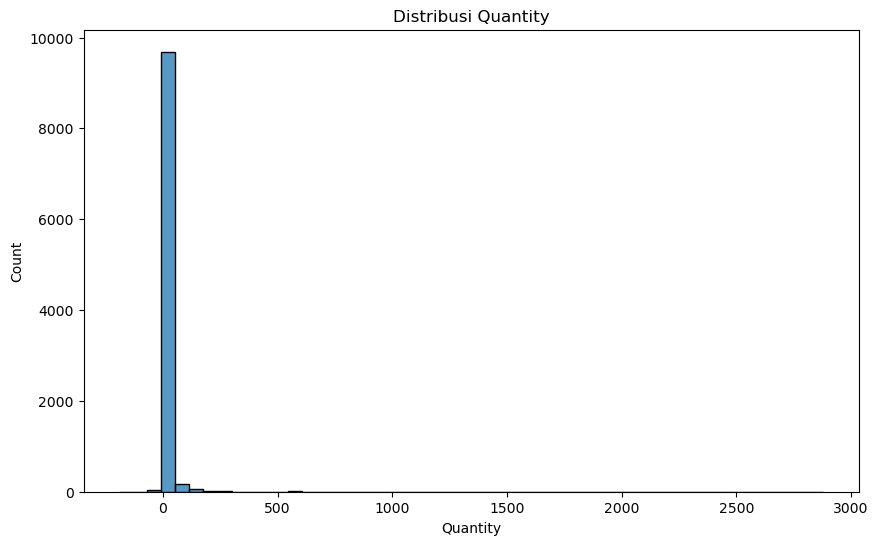

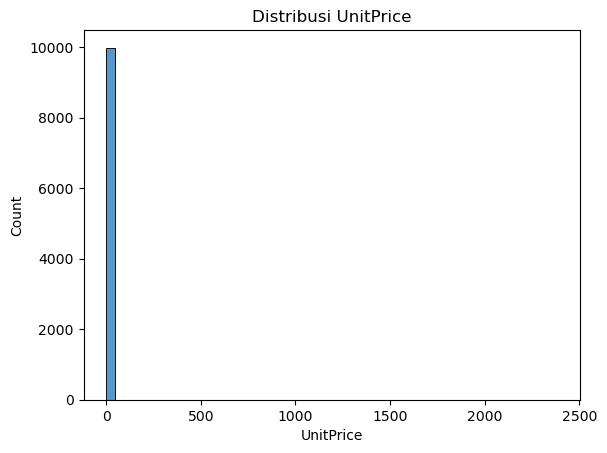

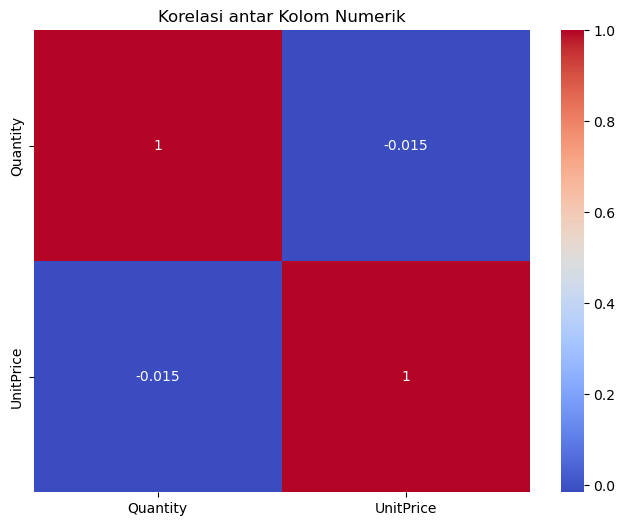

In [17]:
# visualisasi data numerik secara samplenya saja, karena kolom yang banyak 
numeric_columns = data_bersih.select_dtypes(include=['int64', 'float64']).columns
data_numeric = data_bersih[numeric_columns]
# pakai sample size
sample_size = 10000  
data_sample = data_numeric.sample(n=min(sample_size, len(data_numeric)))

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for column in data_numeric.columns:
    sns.histplot(data=data_sample, x=column, bins=50)
    plt.title(f'Distribusi {column}')
    plt.show()


# Melihat korelasi
plt.figure(figsize=(8, 6))
sns.heatmap(data_sample.corr(), annot=True, cmap='coolwarm')
plt.title('Korelasi antar Kolom Numerik')
plt.show()

Kolom numerik tidak berkaitan erat, maka harus menggunakan feature engineering untuk membagi ke dalam kelompok
(akan dilakukan nanti)

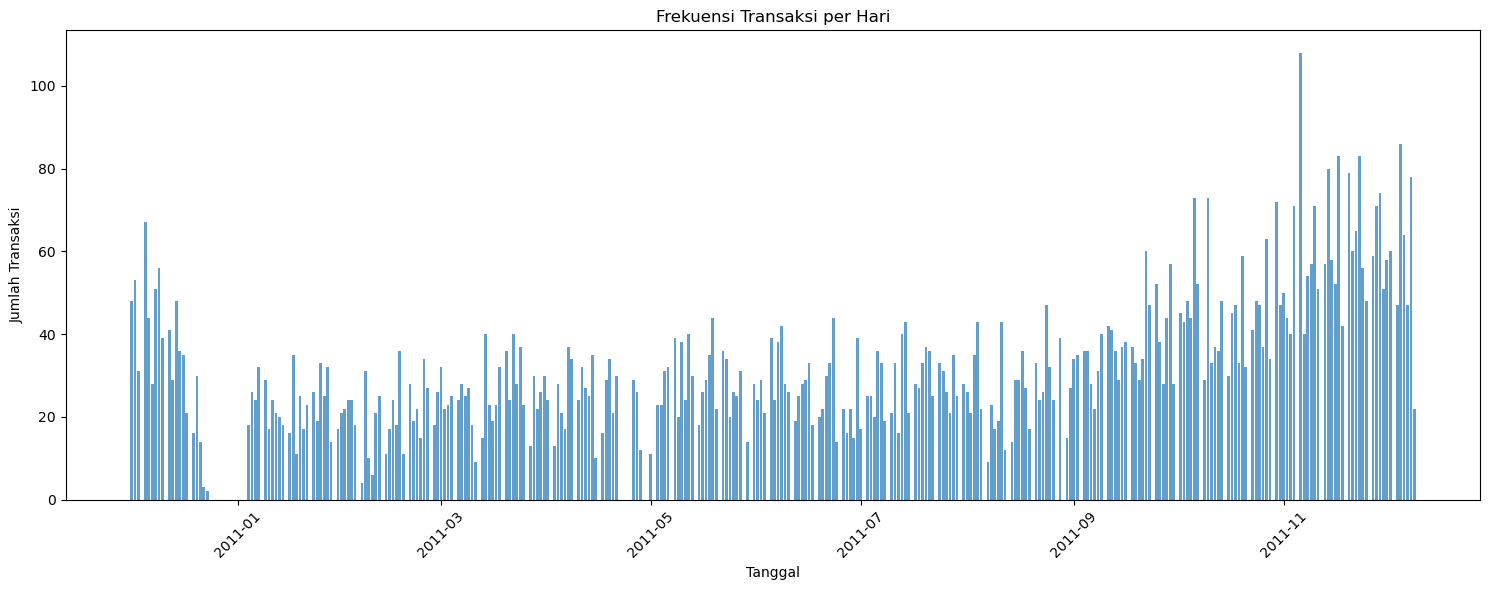

In [19]:
# untuk riwayat tanggal transaksi 
sample_size = 10000
data_sample = data_bersih.sample(n=min(sample_size, len(data_bersih)))

data['InvoiceDate'] = pd.to_datetime(data_sample['InvoiceDate'], format='%d-%m-%Y %H:%M')

# Ambil hanya tanggal (menghapus waktu)
data['InvoiceDate'] = data['InvoiceDate'].dt.date

# Hitung frekuensi per tanggal
daily_frequency = data['InvoiceDate'].value_counts().sort_index()

# Visualisasi
plt.figure(figsize=(15, 6))
plt.bar(daily_frequency.index, daily_frequency.values, alpha=0.7)
plt.title('Frekuensi Transaksi per Hari')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Transaksi')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang perlu dilakukan, namun **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Kita akan menganalisis customer berdasarkan 3 faktor :
1. R (Recency): Jumlah hari sejak transaksi terakhir
2. F (Frequency): Jumlah transaksi
3. M (Monetary): Jumlah profit (barang*harga)
4. C (Country): Pelanggan berasal dari negara mana (dengan frekuensi encoding)

dataset akan bernama : rfm_

data yang kepakai, Quantity, UnitPrice, InvoiceDate, InvoiceNo, CustomerID, Country  

In [21]:
country_distribution = data_bersih['Country'].value_counts()
country_percentage = (data_bersih['Country'].value_counts(normalize=True) * 100).round(2)

# Menggabungkan frekuensi dan persentase
country_stats = pd.DataFrame({
    'Frequency': country_distribution,
    'Percentage': country_percentage
})

# Menampilkan hasil
print(country_stats)

                      Frequency  Percentage
Country                                    
United Kingdom           361878       88.95
Germany                    9495        2.33
France                     8491        2.09
EIRE                       7485        1.84
Spain                      2533        0.62
Netherlands                2371        0.58
Belgium                    2069        0.51
Switzerland                1877        0.46
Portugal                   1480        0.36
Australia                  1259        0.31
Norway                     1086        0.27
Italy                       803        0.20
Channel Islands             758        0.19
Finland                     695        0.17
Cyprus                      622        0.15
Sweden                      462        0.11
Austria                     401        0.10
Denmark                     389        0.10
Japan                       358        0.09
Poland                      341        0.08
USA                         291 

In [23]:
# frequency encoding
country_freq = data_bersih['Country'].value_counts() / len(data_bersih)
data_bersih['Country_encoded'] = data_bersih['Country'].map(country_freq)
rfm_c = data_bersih.groupby('CustomerID')['Country_encoded'].mean().reset_index()
rfm_c.head()

,CustomerID,Country_encoded
0,12346.0,0.889509
1,12347.0,0.000447
2,12348.0,0.001708
3,12349.0,0.001974
4,12350.0,0.002669


In [ ]:
# angka tinggi menunjukkan pelanggan ini berasal dari negara yang sering berbelanja di perusahaan ini

In [25]:
# Monetary
data_bersih['Amount'] = data_bersih['Quantity']*data_bersih['UnitPrice']
rfm_m = data_bersih.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [27]:
# frekuensi
rfm_f = data_bersih.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [29]:
# recency
# Ambil hanya tanggal (menghapus waktu)
data_bersih['InvoiceDate'] = pd.to_datetime(data_bersih['InvoiceDate'], format='%d-%m-%Y %H:%M')
data_bersih['InvoiceDate'] = data_bersih['InvoiceDate'].dt.date
max_date = max(data_bersih['InvoiceDate'])
max_date
data_bersih['Diff'] = max_date - data_bersih['InvoiceDate']
rfm_p = data_bersih.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
# mengekstrak hari saja
rfm_p['Diff'] = rfm_p['Diff'].apply(lambda x: x.days)
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


In [31]:
# digabungkan secara bertahap
rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm = pd.merge(rfm, rfm_c, on='CustomerID', how='left')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency', 'Freq_Country']
rfm.head(10)

,CustomerID,Amount,Frequency,Recency,Freq_Country
0,12346.0,0.00,2,325,0.889509
1,12347.0,4310.00,182,2,0.000447
2,12348.0,1797.24,31,75,0.001708
3,12349.0,1757.55,73,18,0.001974
4,12350.0,334.40,17,310,0.002669
5,12352.0,1545.41,95,36,0.002669
6,12353.0,89.00,4,204,0.000042
7,12354.0,1079.40,58,232,0.006226
8,12355.0,459.40,13,214,0.000042
9,12356.0,2811.43,59,22,0.003638


<Figure size 1500x500 with 0 Axes>

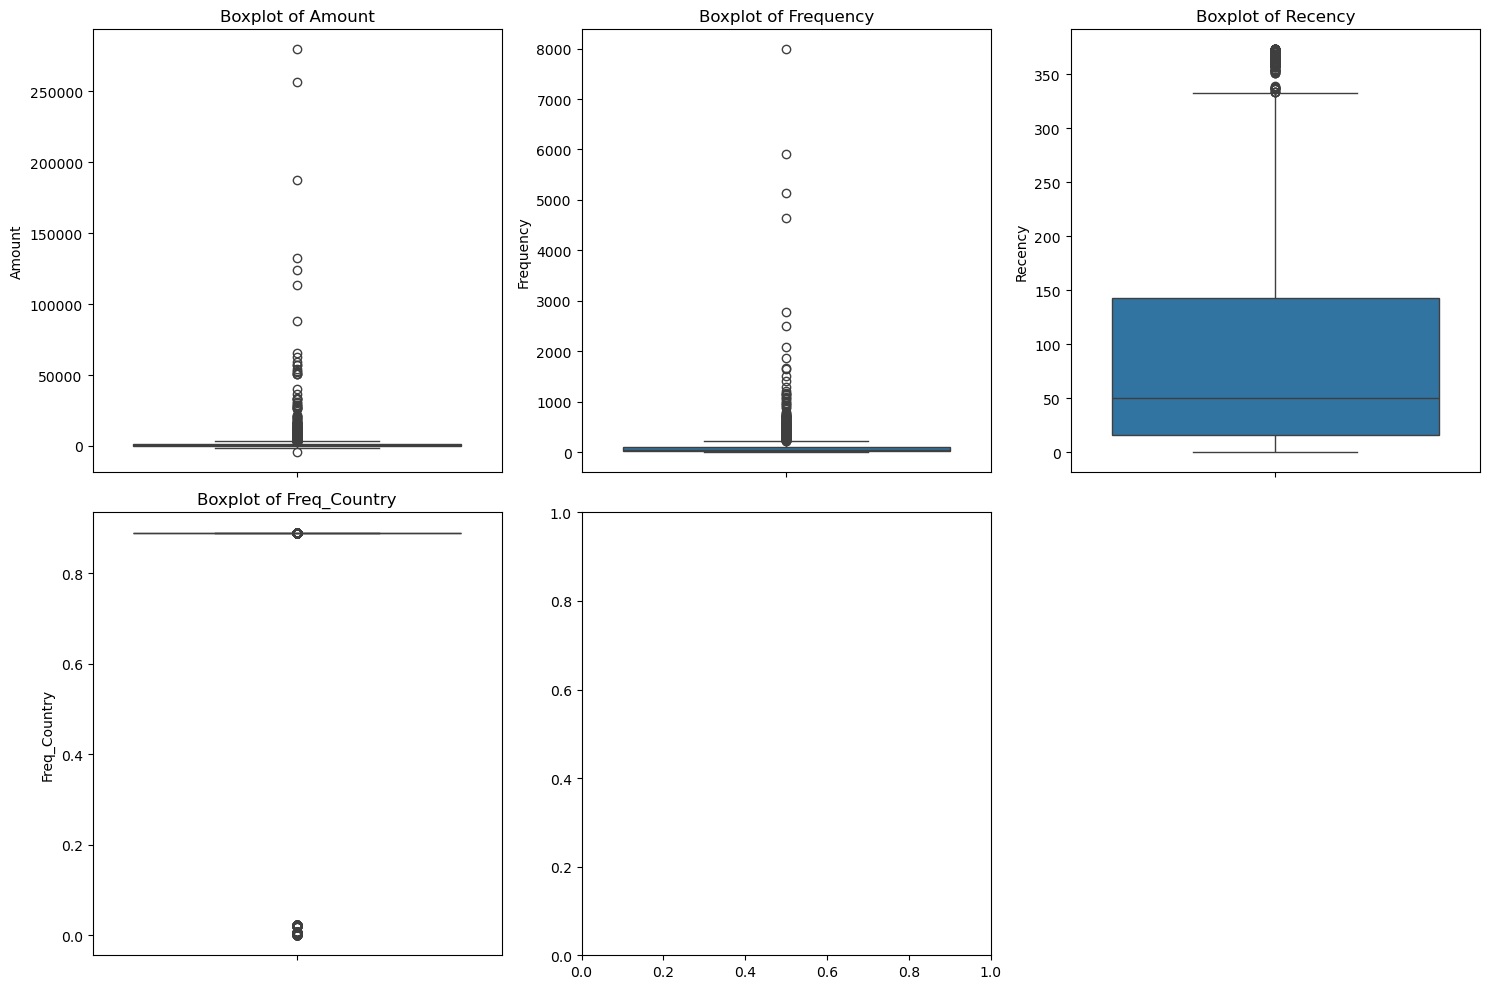

In [33]:
# visualisasi bentuk numeriknya dalam RFM

plt.figure(figsize=(15, 5))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Membuat boxplot untuk setiap kolom
sns.boxplot(y=rfm['Amount'], ax=axes[0, 0])
axes[0, 0].set_title('Boxplot of Amount')
axes[0, 0].set_ylabel('Amount')

sns.boxplot(y=rfm['Frequency'], ax=axes[0, 1])
axes[0, 1].set_title('Boxplot of Frequency')
axes[0, 1].set_ylabel('Frequency')

sns.boxplot(y=rfm['Recency'], ax=axes[0, 2])
axes[0, 2].set_title('Boxplot of Recency')
axes[0, 2].set_ylabel('Recency')

sns.boxplot(y=rfm['Freq_Country'], ax=axes[1, 0])
axes[1, 0].set_title('Boxplot of Freq_Country')
axes[1, 0].set_ylabel('Freq_Country')

fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

In [35]:
# Menghitung statistik untuk melihat detail outlier
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    
    print(f"\nAnalisis Outlier untuk {column}:")
    print(f"Q1: {Q1:.2f}")
    print(f"Q3: {Q3:.2f}")
    print(f"IQR: {IQR:.2f}")
    print(f"Batas bawah: {lower_bound:.2f}")
    print(f"Batas atas: {upper_bound:.2f}")
    print(f"Jumlah Outlier: {len(outliers)}")
    print(f"Persentase Outlier: {(len(outliers)/len(df)*100):.2f}%")
    
    if len(outliers) > 0:
        print("\nStatistik Outlier:")
        print(outliers.describe())

# Mendeteksi outlier untuk setiap variabel
for column in ['Amount', 'Frequency', 'Recency']:
    detect_outliers(rfm, column)


Analisis Outlier untuk Amount:
Q1: 293.36
Q3: 1611.72
IQR: 1318.36
Batas bawah: -1684.18
Batas atas: 3589.27
Jumlah Outlier: 423
Persentase Outlier: 9.68%

Statistik Outlier:
count       423.000000
mean      11638.593144
std       24254.291245
min       -4287.630000
25%        4321.590000
50%        5739.460000
75%        9199.510000
max      279489.020000
Name: Amount, dtype: float64

Analisis Outlier untuk Frequency:
Q1: 17.00
Q3: 102.00
IQR: 85.00
Batas bawah: -110.50
Batas atas: 229.50
Jumlah Outlier: 380
Persentase Outlier: 8.69%

Statistik Outlier:
count     380.000000
mean      493.494737
std       646.755929
min       230.000000
25%       277.750000
50%       344.000000
75%       474.000000
max      7983.000000
Name: Frequency, dtype: float64

Analisis Outlier untuk Recency:
Q1: 16.00
Q3: 143.00
IQR: 127.00
Batas bawah: -174.50
Batas atas: 333.50
Jumlah Outlier: 143
Persentase Outlier: 3.27%

Statistik Outlier:
count    143.000000
mean     361.895105
std       10.728869
min   

In [84]:
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_clean = df.copy()
    df_clean[column] = df_clean[column].astype(float)
    df_clean.loc[df_clean[column] > upper_bound, column] = float(upper_bound)
    df_clean.loc[df_clean[column] < lower_bound, column] = float(lower_bound)
    
    return df_clean

# Copy dataset dan handle outliers
rfm_processed = rfm.copy()
for column in ['Amount', 'Frequency', 'Recency']:
    rfm_processed = handle_outliers(rfm_processed, column)

In [86]:
scaler = StandardScaler()
features = ['Amount', 'Frequency', 'Recency', 'Freq_Country']

# Buat df terpisah untuk data standarisasi
rfm_scaled = pd.DataFrame(
    scaler.fit_transform(rfm_processed[features]),
    columns=features
)

# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Pada tahap ini, Anda membangun model clustering dengan memilih algoritma yang sesuai untuk mengelompokkan data berdasarkan kesamaan. Berikut adalah **rekomendasi** tahapannya.
1. Pilih algoritma clustering yang sesuai.
2. Latih model dengan data menggunakan algoritma tersebut.

* Memilih model yang umum digunakan, yaitu Kmeans dan DBScan *

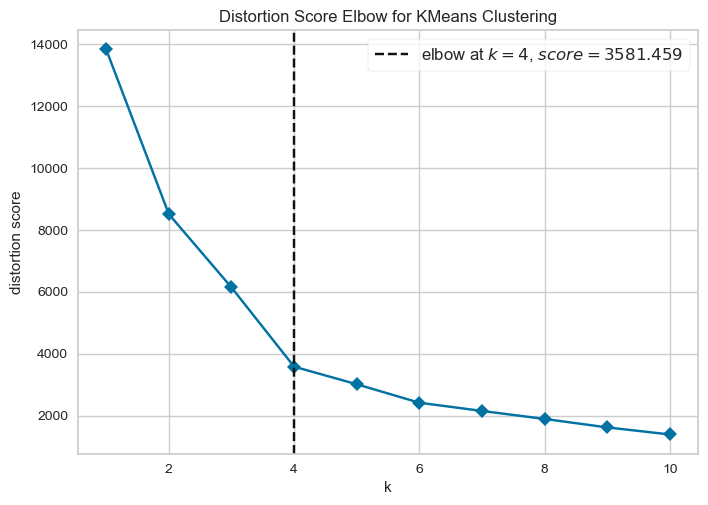

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [88]:
# sebelum memndapat PCA
from yellowbrick.cluster import KElbowVisualizer
import os
os.environ['OMP_NUM_THREADS'] = '5'

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

X_train, X_test = train_test_split(rfm_scaled, test_size=0.2, random_state=42)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 11), metric='distortion', timings=False)
visualizer.fit(X_train)
visualizer.show()

In [90]:
k_values = range(2, 9)
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=30)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score: {score:.3f}")

K=2, Silhouette Score: 0.430
K=3, Silhouette Score: 0.482
K=4, Silhouette Score: 0.486
K=5, Silhouette Score: 0.498
K=6, Silhouette Score: 0.446
K=7, Silhouette Score: 0.432
K=8, Silhouette Score: 0.427


## **b. Evaluasi Model Clustering**

Untuk menentukan jumlah cluster yang optimal dalam model clustering, Anda dapat menggunakan metode Elbow atau Silhouette Score.

Metode ini membantu kita menemukan jumlah cluster yang memberikan pemisahan terbaik antar kelompok data, sehingga model yang dibangun dapat lebih efektif. Berikut adalah **rekomendasi** tahapannya.
1. Gunakan Silhouette Score dan Elbow Method untuk menentukan jumlah cluster optimal.
2. Hitung Silhouette Score sebagai ukuran kualitas cluster.

In [92]:
k_values = range(2, 9)
silhouette_scores = []

# mencoba PCA untuk meningkatkan silhouette_score, dan masukkan ke df 
pca = PCA(n_components=2)
rfm_pca = pd.DataFrame(
    pca.fit_transform(rfm_scaled),
    columns=['Component 1', 'Component 2']
)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=30)
    labels = kmeans.fit_predict(rfm_pca)
    score = silhouette_score(rfm_pca, labels)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score: {score:.3f}")

K=2, Silhouette Score: 0.533
K=3, Silhouette Score: 0.615
K=4, Silhouette Score: 0.519
K=5, Silhouette Score: 0.538
K=6, Silhouette Score: 0.566
K=7, Silhouette Score: 0.557
K=8, Silhouette Score: 0.552


In [94]:
# test dengan DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(rfm_pca)  # rfm_pca adalah data PCA

# Mask untuk mengecualikan noise points (cluster -1)
mask = dbscan_labels != -1  # True untuk data non-noise

# Perhitungan Silhouette Score hanya untuk data non-noise
if sum(mask) > 1:  # Pastikan ada cukup data untuk perhitungan
    silhouette_dbscan = silhouette_score(rfm_pca[mask], dbscan_labels[mask])
    print(f'Silhouette Score for DBSCAN (excluding noise): {silhouette_dbscan:.3f}')
else:
    print("Not enough data points for silhouette score calculation.")


Silhouette Score for DBSCAN (excluding noise): 0.592


In [96]:
# 4. Final Clustering dengan k optimal (k = 3)
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=30)
cluster_labels = kmeans_final.fit_predict(rfm_scaled)

# Tambahkan hasil clustering ke dataframe asli dan scaled
rfm_scaled['Cluster'] = cluster_labels

In [98]:
rfm_scaled.head()

,Amount,Frequency,Recency,Freq_Country,Cluster
0,-0.999609,-0.970596,2.382836,0.326835,2
1,2.208240,1.594564,-0.901414,-3.101285,0
2,0.606644,-0.557320,-0.159153,-3.096423,0
3,0.571172,0.041217,-0.738727,-3.095399,0
4,-0.700745,-0.756832,2.230316,-3.092717,0


## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

## **d. Visualisasi Hasil Clustering**

Setelah model clustering dilatih dan jumlah cluster optimal ditentukan, langkah selanjutnya adalah menampilkan hasil clustering melalui visualisasi.

Berikut adalah **rekomendasi** tahapannya.
1. Tampilkan hasil clustering dalam bentuk visualisasi, seperti grafik scatter plot atau 2D PCA projection.

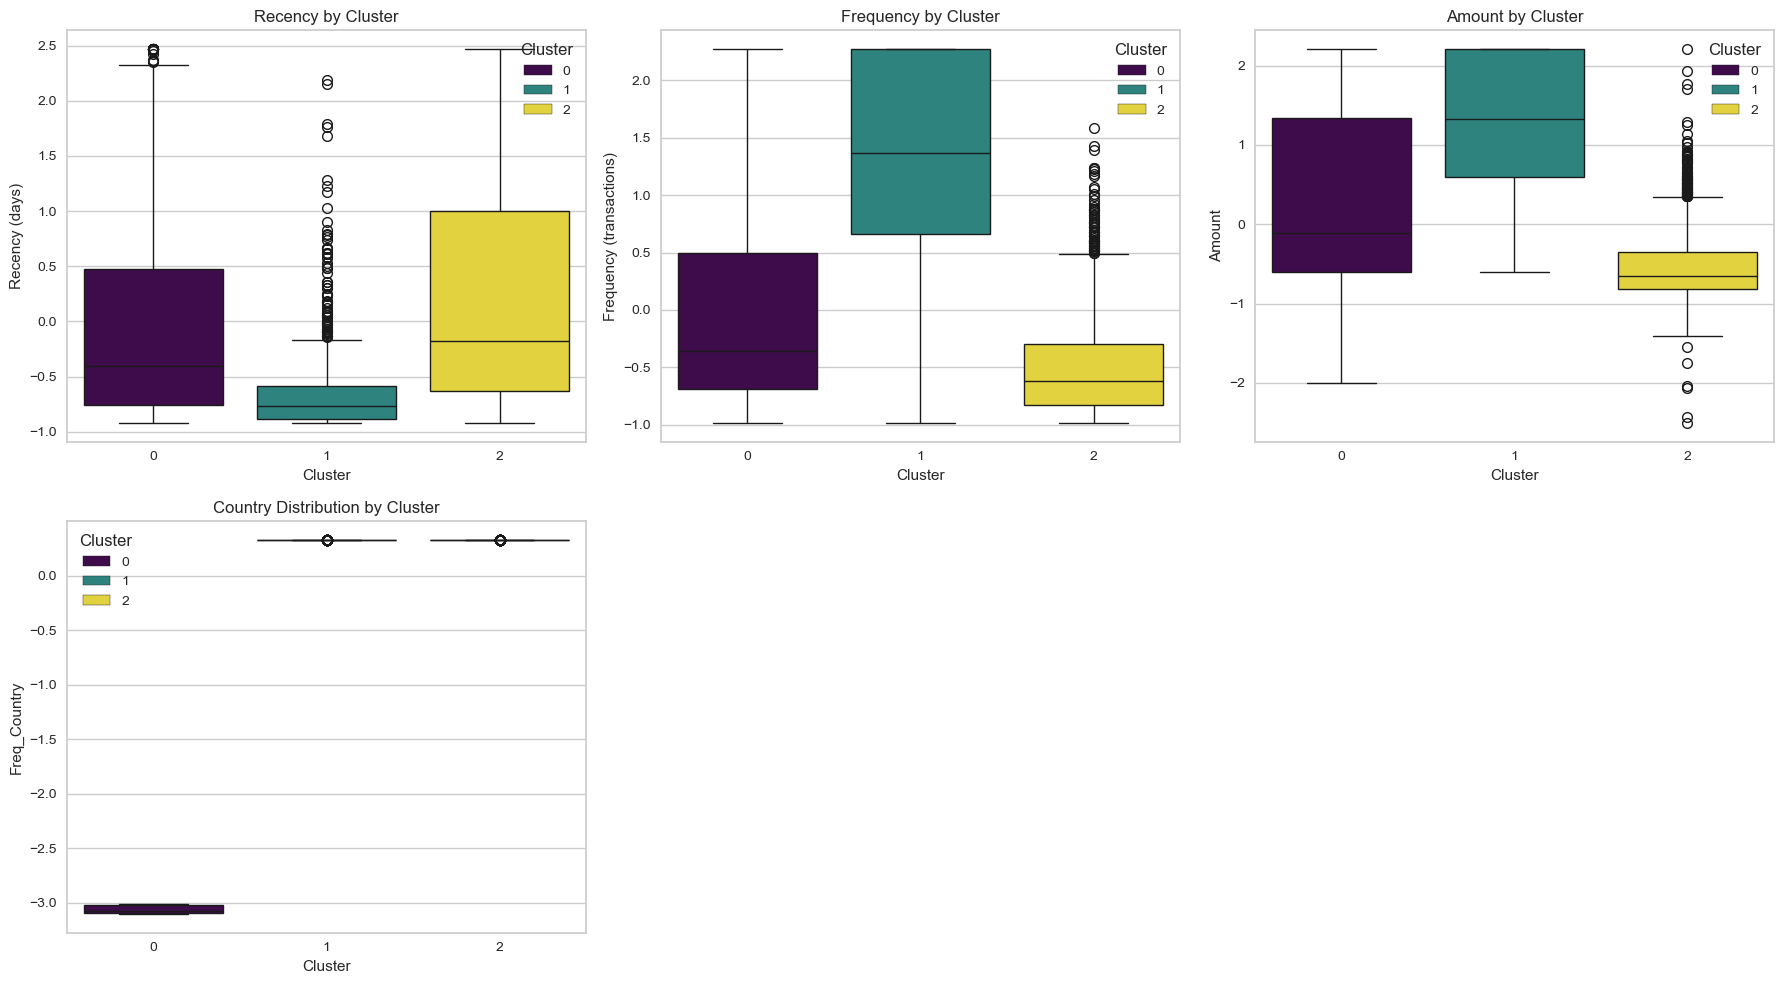

In [100]:

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot untuk Recency
sns.boxplot(x='Cluster', y='Recency', data=rfm_scaled, 
            palette='viridis', hue='Cluster', dodge=False, ax=axes[0, 0])
axes[0, 0].set_title('Recency by Cluster')
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Recency (days)') # Menghapus legenda

# Plot untuk Frequency
sns.boxplot(x='Cluster', y='Frequency', data=rfm_scaled, 
            palette='viridis', hue='Cluster', dodge=False, ax=axes[0, 1])
axes[0, 1].set_title('Frequency by Cluster')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Frequency (transactions)')  # Menghapus legenda

# Plot untuk Amount
sns.boxplot(x='Cluster', y='Amount', data=rfm_scaled, 
            palette='viridis', hue='Cluster', dodge=False, ax=axes[0, 2])
axes[0, 2].set_title('Amount by Cluster')
axes[0, 2].set_xlabel('Cluster')
axes[0, 2].set_ylabel('Amount')  # Menghapus legenda

# Plot untuk Freq_Country
sns.boxplot(x='Cluster', y='Freq_Country', data=rfm_scaled, 
            palette='viridis', hue='Cluster', dodge=False, ax=axes[1, 0])
axes[1, 0].set_title('Country Distribution by Cluster')
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Freq_Country') # Menghapus legenda

# Menghapus sisa plot kosong untuk menjaga layout tetap rapi
fig.delaxes(axes[1, 1])
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()


In [102]:
rfm_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Amount        4372 non-null   float64
 1   Frequency     4372 non-null   float64
 2   Recency       4372 non-null   float64
 3   Freq_Country  4372 non-null   float64
 4   Cluster       4372 non-null   int32  
dtypes: float64(4), int32(1)
memory usage: 153.8 KB


## **e. Analisis dan Interpretasi Hasil Cluster**

Setelah melakukan clustering, langkah selanjutnya adalah menganalisis karakteristik dari masing-masing cluster berdasarkan fitur yang tersedia.

Berikut adalah **rekomendasi** tahapannya.
1. Analisis karakteristik tiap cluster berdasarkan fitur yang tersedia (misalnya, distribusi nilai dalam cluster).
2. Berikan interpretasi: Apakah hasil clustering sesuai dengan ekspektasi dan logika bisnis? Apakah ada pola tertentu yang bisa dimanfaatkan?

Tulis hasil interpretasinya di sini.
1. Cluster 0 (biasa):
   1. recency rata-rata - 0.3 (menengah), menunjukkan waktu pembelian terakhir yang moderat dibandingkan rata-rata.  
   2. frequency rata-rata -0.3 (menengah), menunjukkan frekuensi pembelian yang moderat dibandingkan dengan rata-rata.
   3. amount rata-rata -0.1 (menengah), menunjukkan nilai pembelian yang moderat.
   4. freq_count rata-rata -3.0 (rendah), mengindikasikan pelanggan dominan berasal dari negara dengan frekuensi rendah (bukan UK). 
   5. Analisis: Cluster ini merepresentasikan pelanggan dengan nilai moderat yang cenderung berasal dari luar UK. Nilai transaksi mereka baik, masih aktif berbelanja dan frekuensi pembelian mereka relatif rendah. Hal ini mungkin disebabkan oleh faktor geografis dan biaya pengiriman internasional.
2. Cluster 1 (tinggi/terbaik):
   1. recency rata-rata - 0.7 (rendah), menunjukkan pelanggan yang paling baru melakukan transaksi.
   2. frequency rata-rata 1.2 (tinggi), menunjukkan frekuensi pembelian tertinggi di antara semua cluster.
   3. amount rata-rata 0.5 (tinggi), menunjukkan nilai pembelian yang di atas rata-rata.
   4. freq_count rata-rata 0.1 (tinggi), mengindikasikan pelanggan dominan berasal dari negara UK. 
   5. Analisis: Cluster ini adalah segmen pelanggan paling berharga dengan karakteristik high-frequency dan high-value. Pelanggan dalam cluster ini sangat aktif, sering berbelanja dengan nilai transaksi tinggi, dan mayoritas berasal dari UK, yang menunjukkan efektivitas strategi pemasaran domestik.
3. Cluster 2 (rendah/beresiko):
   1. recency rata-rata - 0.1 (tinggi), menunjukkan pelanggan yang sudah lama tidak melakukan transaksi.
   2. frequency rata-rata -0.7 (rendah), menunjukkan frekuensi pembelian terendah di antara semua cluster.
   3. amount rata-rata -0.6 (rendah), menunjukkan nilai pembelian yang terendah.
   4. freq_count rata-rata 0.1 (tinggi), mengindikasikan pelanggan dominan berasal dari negara UK, tetapi juga bisa dari negara-negara lain. 
   5. Analisis: Cluster ini terdiri dari pelanggan yang berisiko tinggi untuk pindah ke perusahaan lain. Cluster dengan recency tinggi dan frequency rendah, amount rendah, freq_count tinggi menunjukkan bahwa pelanggan yang mungkin sudah tidak aktif, sudah lama tidak bertransaksi, frekuensi transaksi rendah, total belanja rendah, dan berasal dari berbagai negara 

Interpretasi : 
Hasil Clustering sudah sesuai dengan logika bisnis, di mana dapat dilihat karena perusahaan ini berasal dari UK, maka wajar jika pelanggan terbaiknya juga berasal dari UK. Berdasarkan pola ini, terdapat beberapa rekomendasi :

Untuk Cluster 1:
1. Pertahankan dengan program loyalty
2. Tawarkan produk premium
3. Berikan early access ke produk baru


Untuk Cluster 0:
1. Program aktivasi untuk meningkatkan frequency
2. Promosi yang disesuaikan dengan karakteristik regional


Untuk Cluster 2:
1. Program win-back
2. Survei untuk memahami alasan tidak aktif
3. Promosi khusus untuk mendorong pembelian ulang

In [ ]:
# tambahan kode jika ingin melihat customerID 
rfm_scaled['Costumer ID'] = rfm['Costumer ID']
rfm_scaled.head()

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.

In [106]:
# tidak perlu menyimpan customerID lagi untuk klasifikasi, simpan ke csv
rfm_scaled.to_csv('rfm_classification.csv', index=False) 

# **6. Pembangunan Model Clustering**